# Stock Price Forecast

# Introduction

Under Construction

# Imports & Data Load

In [1]:
#Imports
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import yfinance as yf
from yahoofinancials import YahooFinancials
from pandas_datareader import data

In [2]:
## Reading 4 different Stock Prices that can be used in this work

# Ibovespa, S&P BSE SENSEX, Nasdaq, Dow Jones Industrial Average

bvsp_raw_data = yf.download('^BVSP', start='2016-01-01', end='2023-01-01', progress=False) # ibovespa
bsesn_raw_data = yf.download('^BSESN', start='2016-01-01', end='2023-01-01', progress=False) # S&P BSE SENSEX
ixic_raw_data = yf.download('^IXIC', start='2016-01-01', end='2023-01-01', progress=False) # Nasdaq
dji_raw_data = yf.download('^DJI', start='2016-01-01', end='2023-01-01', progress=False) # Dow Jones Industrial Average

In [3]:
# Oppening Raw Data
bvsp_raw_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,43349.0,43349.0,42125.0,42141.0,42141.0,2976300
2016-01-05,42139.0,42534.0,42137.0,42419.0,42419.0,2557200
2016-01-06,42410.0,42410.0,41590.0,41773.0,41773.0,3935900
2016-01-07,41772.0,41772.0,40695.0,40695.0,40695.0,4032300
2016-01-08,40695.0,41218.0,40463.0,40612.0,40612.0,3221600
...,...,...,...,...,...,...
2022-12-23,107552.0,109994.0,107552.0,109698.0,109698.0,12847100
2022-12-26,109699.0,109755.0,108309.0,108738.0,108738.0,5219500
2022-12-27,108739.0,109353.0,107418.0,108347.0,108347.0,11158100


# Preprocessing

OBS: BVSP (Ibovespa) data will be used as reference for this work, because it has the highest stock price than others

In [4]:
## Renaming the "Adj Close" column to remove the 'space' character from the column name (to avoid future errors)
bvsp_data = bvsp_raw_data.rename({'Adj Close': 'Adj_Close'}, axis=1)
bsesn_data = bsesn_raw_data.rename({'Adj Close': 'Adj_Close'}, axis=1)
ixic_data = ixic_raw_data.rename({'Adj Close': 'Adj_Close'}, axis=1)
dji_data = dji_raw_data.rename({'Adj Close': 'Adj_Close'}, axis=1)

In [5]:
# Printing Data Keys
bvsp_data.keys()

Index(['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume'], dtype='object')

In [6]:
# Data size
bvsp_data.shape

(1734, 6)

In [7]:
# Describe data rounding values
round(bvsp_data.describe(), 2)

,Open,High,Low,Close,Adj_Close,Volume
count,1734.00,1734.00,1734.00,1734.00,1734.00,1734.00
mean,89804.78,90684.88,88948.66,89842.20,89842.20,6827986.85
std,22742.16,22862.20,22570.60,22719.74,22719.74,4178819.83
min,37501.00,38031.00,37046.00,37497.00,37497.00,0.00
25%,71409.00,72637.75,70787.50,71507.50,71507.50,3545800.00
50%,95385.00,96359.50,94352.50,95378.00,95378.00,5088750.00
75%,108922.50,110113.00,108071.25,108952.50,108952.50,10027525.00
max,130776.00,131190.00,129526.00,130776.00,130776.00,26029300.00


In [8]:
# Data Info
bvsp_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1734 entries, 2016-01-04 to 2022-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1734 non-null   float64
 1   High       1734 non-null   float64
 2   Low        1734 non-null   float64
 3   Close      1734 non-null   float64
 4   Adj_Close  1734 non-null   float64
 5   Volume     1734 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 94.8 KB


In [9]:
## Unadjusted closing prices can be used to calculate returns, but adjusted closing prices save you some time and effort. 

## Adjusted prices are already adjusted for stock dividends, cash dividends and splits, ...
##                                     ...which creates a more accurate return calculation.


#Looking only to 'Adj_Close' Feature
bvsp_adj_close = bvsp_data['Adj_Close']
bsesn_adj_close = bsesn_data['Adj_Close']
ixic_adj_close = ixic_data['Adj_Close']
dji_adj_close = dji_data['Adj_Close']

#Rolling Mean & Std
rollingseries_bvsp_adj_close = bvsp_adj_close.rolling(window=10) #2-weekly Window (10 days) [NO WEEKEND]
rollingmean_bvsp_adj_close = rollingseries_bvsp_adj_close.mean() #mean
rolling_std_bvsp_adj_close = rollingseries_bvsp_adj_close.std() #Std

rollingseries_bsesn_adj_close = bsesn_adj_close.rolling(window=10)
rollingmean_bsesn_adj_close = rollingseries_bsesn_adj_close.mean()
rolling_std_bsesn_adj_close = rollingseries_bsesn_adj_close.std()

rollingseries_ixic_adj_close = ixic_adj_close.rolling(window=10)
rollingmean_ixic_adj_close = rollingseries_ixic_adj_close.mean()
rolling_std_ixic_adj_close = rollingseries_ixic_adj_close.std()

rollingseries_dji_adj_close = dji_adj_close.rolling(window=10)
rollingmean_dji_adj_close = rollingseries_dji_adj_close.mean()
rolling_std_dji_adj_close = rollingseries_dji_adj_close.std()



# Let's create a DataFrame that will contain data about the adjusted closing
Close_Df = pd.DataFrame(columns=['bvsp','bsesn','ixic','dji'])
Close_Df['bvsp'] = round(bvsp_adj_close,2)
Close_Df['bsesn'] = round(bsesn_adj_close,2)
Close_Df['ixic'] = round(ixic_adj_close,2)
Close_Df['dji'] = round(dji_adj_close,2)

Close_Df


,bvsp,bsesn,ixic,dji
Date,,,,
2016-01-04,42141.0,25623.35,4903.09,17148.94
2016-01-05,42419.0,25580.34,4891.43,17158.66
2016-01-06,41773.0,25406.33,4835.76,16906.51
2016-01-07,40695.0,24851.83,4689.43,16514.10
2016-01-08,40612.0,24934.33,4643.63,16346.45
...,...,...,...,...
2022-12-23,109698.0,59845.29,10497.86,33203.93
2022-12-26,108738.0,60566.42,NaN,NaN
2022-12-27,108347.0,60927.43,10353.23,33241.56


# Data Visualization

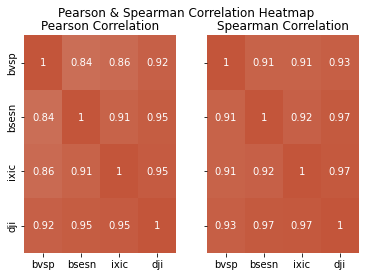

In [10]:
# Heatmap for Pearson and Spearman Correlation for Close Values between the Market Indices
close_corr_pearson = Close_Df.corr(method ='pearson')
close_corr_spearman = Close_Df.corr(method ='spearman')

cmap = sns.diverging_palette(230, 20, as_cmap=True) # or use 'coolwarm'

f,(ax1,ax2) = plt.subplots(1,2,sharey=True)
f.suptitle('Pearson & Spearman Correlation Heatmap')

# Pearson
g1 = sns.heatmap(close_corr_pearson,cmap=cmap,cbar=False,ax=ax1, annot=True, vmin=-1, vmax=1)
g1.set_ylabel('')
g1.set_xlabel('')
g1.title.set_text( "Pearson Correlation" )

# Spearman
g2 = sns.heatmap(close_corr_spearman,cmap=cmap,cbar=False,ax=ax2, annot=True, vmin=-1, vmax=1)
g2.set_ylabel('')
g2.set_xlabel('')
g2.title.set_text( "Spearman Correlation" )

plt.show()

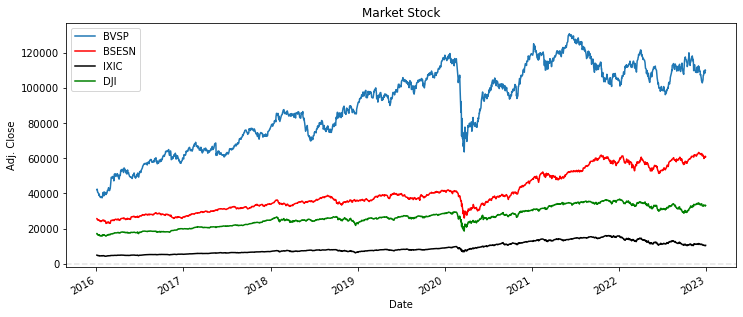

In [11]:
## 'Adj_Close' Plot for each Stock Price

plt.figure(figsize=(12, 5))

bvsp_adj_close.plot(label = 'BVSP')
#rollingmean_bvsp_adj_close.plot(alpha= 0.5, label = 'BVSP_Rolling Mean', color='r')  #for plot rolling mean
bsesn_adj_close.plot(label = 'BSESN', color='r')
ixic_adj_close.plot(label = 'IXIC', color='black')
dji_adj_close.plot(label = 'DJI', color='g')


plt.axhline(0, ls='--', color='black', alpha = 0.1 )
plt.legend(loc = 'best')
plt.title('Market Stock')
plt.ylabel('Adj. Close')
plt.show()

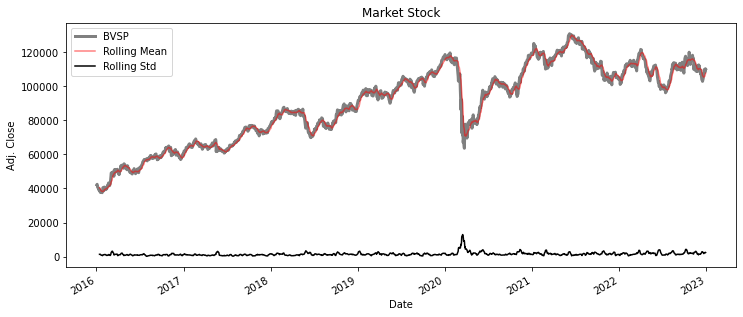

In [12]:
## BVSP 'Adj_Close' plot, with rolling Mean and Std

plt.figure(figsize=(12, 5))

bvsp_adj_close.plot(color= 'gray', label = 'BVSP', linewidth = 3)
rollingmean_bvsp_adj_close.plot(color= 'red', alpha= 0.5, label = 'Rolling Mean')
rolling_std_bvsp_adj_close.plot(color= 'black', label = 'Rolling Std')


plt.legend(loc = 'best')
plt.title('Market Stock')
plt.ylabel('Adj. Close')
plt.show()

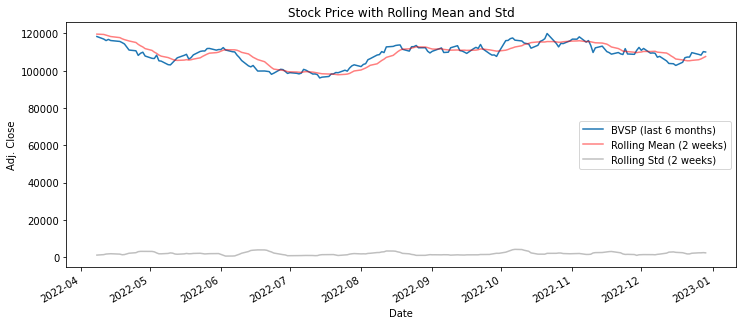

In [13]:
# 6 Months plot for BVSP Stock Prince, and for Rolling Mean and Std

plt.figure(figsize=(12, 5))

bvsp_adj_close[-183:].plot(label = 'BVSP (last 6 months)')
rollingmean_bvsp_adj_close[-183:].plot(color= 'red', alpha= 0.5, label = 'Rolling Mean (2 weeks)')
rolling_std_bvsp_adj_close[-183:].plot(color= 'gray', alpha= 0.5, label = 'Rolling Std (2 weeks)')

plt.legend(loc = 'best')
plt.title('Stock Price with Rolling Mean and Std')
plt.ylabel('Adj. Close')
plt.show()

In [14]:
import plotly.graph_objects as go

# Candlestick Plot for Business Plots
trace1 = {
    'x': bvsp_data.index,
    'open': bvsp_data.Open,
    'close': bvsp_data.Adj_Close,
    'high': bvsp_data.High,
    'low': bvsp_data.Low,
    'type': 'candlestick',
    'name': 'BVSP',
    'showlegend': True
}
data = [trace1]
layout = go.Layout()
fig = go.Figure(data=data, layout=layout)

fig.show()

# Decomposition and stationarity check practicals

In [15]:
from statsmodels.tsa.stattools import adfuller


# Augmented Dickey Fuller Test (ADF Test) for Decomposition and Stationarity checks
adft = adfuller(bvsp_adj_close, autolag="AIC")


output_df = pd.DataFrame({"Values":[adft[0], adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})

output_df

,Values,Metric
0,-2.310096,Test Statistics
1,0.168733,p-value
2,11.000000,No. of lags used
3,1722.000000,Number of observations used
4,-3.434153,critical value (1%)
5,-2.863220,critical value (5%)
6,-2.567664,critical value (10%)


In [16]:
# We can see that our data is not stationary from the fact that 
# our p-value is greater than 5 percent and 
# the test statistic is greater than the critical value. 
# We can also draw these conclusions from inspecting the data, 
# as we see a clear, increasing trend in the close_adj.

autocorrelation_lag1 = bvsp_adj_close.autocorr(lag=30)
print("One Month Lag: ", autocorrelation_lag1)

autocorrelation_lag3 = bvsp_adj_close.autocorr(lag=90)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = bvsp_adj_close.autocorr(lag=180)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = bvsp_adj_close.autocorr(lag=270)
print("Nine Month Lag: ", autocorrelation_lag9)

One Month Lag:  0.9321674189173834
Three Month Lag:  0.8446294384718377
Six Month Lag:  0.7662127736002862
Nine Month Lag:  0.7419694101616764


#

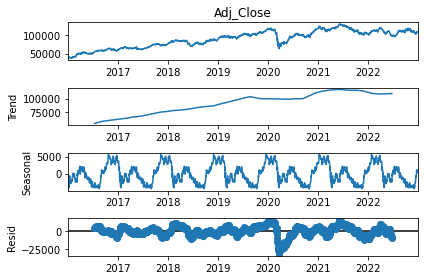

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Serie Decomposition
decompose = seasonal_decompose(bvsp_adj_close, model='additive', period=260) # 260 = number of year util days
# obs: model can be multiplicative 

decompose.plot()
plt.show()

In [18]:
decompose_df_aux = pd.concat([decompose.seasonal, decompose.trend, decompose.resid, decompose.observed], axis=1)
decompose_df_aux.columns = ['seasoanilty', 'trend', 'residual', 'actual_values']
decompose_df = pd.DataFrame(decompose_df_aux, columns = decompose_df_aux.columns)

decompose_df

,seasoanilty,trend,residual,actual_values
Date,,,,
2016-01-04,-1605.520124,NaN,NaN,42141.0
2016-01-05,-3737.252816,NaN,NaN,42419.0
2016-01-06,-3856.373649,NaN,NaN,41773.0
2016-01-07,-3895.779739,NaN,NaN,40695.0
2016-01-08,-4111.806342,NaN,NaN,40612.0
...,...,...,...,...
2022-12-23,310.098786,NaN,NaN,109698.0
2022-12-26,259.659043,NaN,NaN,108738.0
2022-12-27,403.002312,NaN,NaN,108347.0


# Simple Train/Test Split

In [19]:
# adjusting data for algorithms
bvsp_adj_close_auxx = bvsp_adj_close
df = pd.DataFrame(data=bvsp_adj_close_auxx.values, columns=['Adj_Close'])
df['Date'] = bvsp_adj_close.index

df

,Adj_Close,Date
0,42141.0,2016-01-04
1,42419.0,2016-01-05
2,41773.0,2016-01-06
3,40695.0,2016-01-07
4,40612.0,2016-01-08
...,...,...
1729,109698.0,2022-12-23
1730,108738.0,2022-12-26
1731,108347.0,2022-12-27
1732,110237.0,2022-12-28


C:\Users\Pichau\AppData\Local\Temp/ipykernel_19900/1806267177.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Pichau\AppData\Local\Temp/ipykernel_19900/1806267177.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



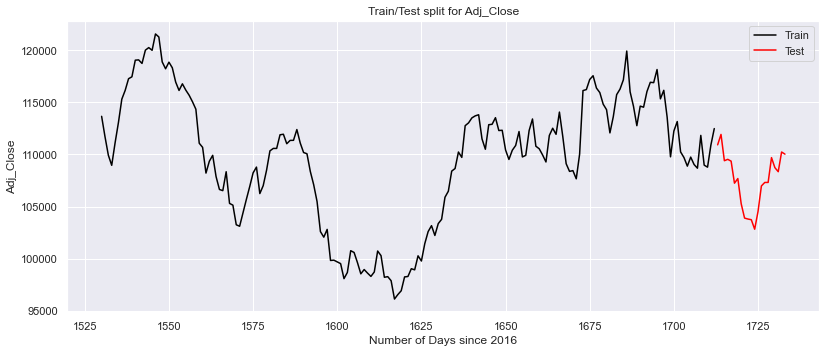

In [39]:
#Using only, for Forecast, the last month how Test Data

#split_date will be use for train/test split
split_date = pd.to_datetime("2022-12", format='%Y-%m')

train = df[(df['Date']) < (split_date)]
train['train'] = train['Adj_Close']
del train['Date']
del train['Adj_Close']

test = df[(df['Date']) >= (split_date)]
test['test'] = test['Adj_Close']
del test['Date']
del test['Adj_Close']

plt.figure(figsize=(12, 5))
plt.plot(train[-183:], color = "black", label = 'Train')
plt.plot(test, color = "red", label = 'Test')
plt.title("Train/Test split for Adj_Close")
plt.ylabel("Adj_Close")
plt.xlabel('Number of Days since 2016')
plt.legend(loc = 'best')
plt.style.use("fivethirtyeight")
sns.set()
plt.show()

# ARIMA


Explaining the ARIMA Model (under Construction)

![](arima.webp)  

Auto-Regressive (p) -> Number of autoregressive terms.

Integrated (d) -> Number of nonseasonal differences needed for stationarity.

Moving Average (q) -> Number of lagged forecast errors in the prediction equation.

In the Auto ARIMA model, note that small p,d,q values represent non-seasonal components, and capital P, D, Q represent seasonal components. It works similarly like hyper tuning techniques to find the optimal value of p, d, and q with different combinations and the final values would be determined with the lower AIC, BIC parameters taking into consideration.


In [ ]:
#Using ARIMA Model for forecast

from pmdarima.arima import auto_arima

model = auto_arima(train, 
                    start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5, m=12, 
                    seasonal=True, error_action='warn', trace = True, suppress_warnings=True, stepwise=True, random_state=32, n_fits = 50, 
                    test= 'adf')
#model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)

In [ ]:
model.fit(train)
forecast, confint = model.predict(n_periods=len(test), return_conf_int=True)
forecast_df = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])
confint_df= pd.DataFrame(confint)

In [ ]:
model.summary()

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(train[-250:], color = "black", label = 'Train')
plt.plot(test, color = "red", alpha = 0.5, label = 'Test')
plt.plot(forecast, color = 'green', alpha = 0.5, label = 'Predicted')
plt.title("Train/Test/Forecast split for Adj_Close")
plt.ylabel("Adj_Close")
plt.xlabel('Year-Month')
plt.legend(loc = 'best')
sns.set()
plt.show()

In [ ]:
#Mostramos la gráfica con la predicción de los 2 últimos años en naranja
#sobre la serie real 

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(df['Adj_Close'][-200:], label= 'Real Data')
ax.plot(forecast_df, label= 'Predicted')
ax.fill_between(forecast_df.index,
                confint_df[0],
                confint_df[1],
                color='grey',alpha=.3, label='Error')

plt.legend(loc='upper left')
plt.show()

In [ ]:
model.plot_diagnostics(figsize=(14,10))
plt.show()

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


mse = mean_squared_error(test, forecast)
rms = sqrt(mse)
r2 = r2_score(test, forecast)

print("RMSE: ", rms)
print("R2 Score: ", r2)

## Time Series Cross-Validation

The method that can be used for cross-validating the time-series model is cross-validation on a rolling basis. Start with a small subset of data for training purpose, forecast for the later data points and then checking the accuracy for the forecasted data points. The same forecasted data points are then included as part of the next training dataset and subsequent data points are forecasted.

To make things intuitive, here is an image for same:

![](TS_cv.webp)  


The idea of cross-validation should be more straightforward to grasp when we look at an example. Imagine that we have only 5 observations in our cross-validation set and we want to perform 4-fold cross-validation.

Here is the dataset: [1, 2, 3, 4, 5]

What we need to do is to create 4 pairs of training/test sets that follow those two rules:

every test set contains unique observations
observations from the training set occur before their corresponding test set
There is only one way to generate such pairs from my dataset. As a result, I get 4 pairs of training/test sets:

Training: [1]  /  Test: [2]

Training: [1, 2] / Test: [3]

Training: [1, 2, 3] / Test: [4]

Training: [1, 2, 3, 4] / Test: [5]

Compute the average of the accuracies of the 4 test fold.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit


X_train_Df = []
X_test_Df = []

for i in range(10):
    X_train_Df.append([])
    X_test_Df.append([])


forecast_df_cv = []
confint_df_cv = []
models = []

rmse = []

tscv = TimeSeriesSplit(n_splits=4)

X = df['Adj_Close']

for idx,(train_index, test_index) in enumerate(tscv.split(X)): 
    X_train, X_test = X[train_index], X[test_index]

    print('Fold: ', (idx+1))
    X_train_Df.append(X_train)
    X_test_Df.append(X_test)


    model = auto_arima(X_train, 
                    start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5, m=12, 
                    seasonal=True, error_action='ignore', trace = True, suppress_warnings=True, stepwise=True, random_state=32, n_fits = 50, 
                    test= 'adf')

    model.fit(X_train)
    models.append(model)

    forecast, confint = model.predict(n_periods=len(X_test), return_conf_int=True)
    forecast_df_cv.append(pd.DataFrame(forecast,index = X_test.index,columns=['Prediction']))
    confint_df_cv.append(pd.DataFrame(confint))

    true_values = X_test
    rmse.append(np.sqrt(mean_squared_error(true_values, forecast)))




In [ ]:
print("RMSE: {}".format(round(np.mean(rmse), 2)), "+- {}".format(round(np.std(rmse),2)))

In [ ]:
#def normalize_data(df):
#    scaler = sklearn.preprocessing.MinMaxScaler()
#    df['DOM_MW']=scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))
#    return df
#
#df_norm = normalize_data(df)
#df_norm.shape
#
#

In [ ]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

In [ ]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

# FBProphet

# LSTM

In [ ]:
# LSTM

lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

In [ ]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)

# UNDER CONSTRUCTION...

In [ ]:
from IPython import display
display.Image("https://ps.w.org/easy-under-construction/assets/icon-256x256.png")

In [36]:
plt.figure(figsize=(20,14))
decompos.plot().suptitle('nAdditive Decompose', fontsize=5)
plt.show()

NameError: name 'add_result' is not defined

<Figure size 1440x1008 with 0 Axes>

## ADfuller test for stationary

In [ ]:
from statsmodels.tsa.stattools import adfuller

adfuller_result = adfuller(bvsp_adj_close, autolag='AIC')
print(f'ADF Statistic: {adfuller_result[0]}')
print(f'p-value: {adfuller_result[1]}')
for key, value in adfuller_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# RNN